Poniżej przedstawiam przykładowy proces modelowania danych do oceny odpowiedzi na kampanię marketingową.
Użyty zbiór do analizy można znaleźć na 'https://dataminingconsultant.com/data/Clothing_Store'
Przedstawia on dane zebrane podczas kampanii marketingowej sklepu odzieżowego w Wielkiej Brytanii. Według metodologii CRISP-DM możemy wyróżnić 6 etapów modelowania danych podczas procesu data miningu i na tyle etapów została też podzielona poniższa analiza.

### 1. Zrozumienie uwarunkowań biznesowych 
Zagadnienie, którym będę się poniżej zajmował to klasyfikacja klientów sklepu na tych, którym warto wysyłać materiały promocyjne i na takich, do których nie warto kierować oferty. Chcę wiedzieć, jak zyskowna będzie kampania marketingowa przeprowadzona w przyszłości i do jakiej grupy docelowej należy ją skierować. Odpowiedź na pierwsze pytanie jest w tym wypadku kryterium oceny modeli - interesują mnie takie, które pozwolą maksymalizować zysk. Zbuduję więc teoretyczną tabelę zysków/kosztów.

In [57]:
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
data = pd.read_csv('~/Downloads/Clothing_Store', sep=',')

In [3]:
data.head()

,HHKEY,ZIP_CODE,REC,FRE,MON,CC_CARD,AVRG,PC_CALC20,PSWEATERS,PKNIT_TOPS,...,VALPHON,WEB,MAILED,RESPONDED,RESPONSERATE,HI,LTFREDAY,CLUSTYPE,PERCRET,RESP
0,9955600066402,1001,208,2,368.46,0,184.23,11,0.18,0.00,...,N,0,5,0,0.00,31.81,111.00,10,0.00,0
1,9955600073501,1028,6,4,258.00,1,64.50,11,0.26,0.16,...,Y,0,4,2,50.00,32.72,43.50,10,0.03,1
2,9955600076313,1056,327,2,77.00,0,38.50,11,1.00,0.00,...,N,0,4,0,0.00,100.00,68.60,16,0.00,0
3,9955600078045,1118,66,8,846.06,1,105.75,11,0.38,0.00,...,Y,0,9,6,66.67,23.27,26.96,10,0.00,0
4,9955600078517,1107,49,1,87.44,0,87.44,11,0.20,0.20,...,Y,0,0,0,0.00,28.52,24.50,20,0.00,0


Bez informacji o marży na poszczególnych produktach ciężko wyliczyć dokładny zysk dla poszczególnych obserwacji. Jednak nie potrzebuję dokładnej wartości a jedynie przybliżenie, dzięki któremu będę w stanie porównać modele. W zbiorze zmienna AVRG przedstawia średnią wartość zakupów dokonaną w sklepie. Założę, iż zysk sklepu wyniesie około 25% przeciętnej wartości zakupów. 

In [4]:
data['AVRG'].isnull().values.any()

False

In [5]:
data['AVRG'].describe()

count    21740.000000
mean       113.889105
std         87.249794
min          0.490000
25%         60.990000
50%         92.070000
75%        139.505000
max       1919.880000
Name: AVRG, dtype: float64

In [6]:
pz = data['AVRG'].mean()*0.25 # Przeciętny zysk


In [7]:
wynik = np.array(['TN', 'TP', 'FN', 'FP'])
klas = np.array(['brak odpowiedzi', 'odpowiedź', 'brak odpowiedzi', 'odpowiedż']) # Klasyfikacja
rodp = np.array(['brak odpowiedzi', 'odpowiedź', 'odpowiedź', 'brak odpowiedzi']) # Rzeczywista odpowiedź
koszt = np.array([0, 2 - pz, pz, 2 ]) # Koszty klasyfikacji
uz = np.array(['brak kontaktu, brak straconych zysków', 'oszacowany zysk minus koszt wysyłki', 'stracony zysk, brak kosztu wysyłki',
     'koszt wysyłki'])
zk = pd.DataFrame({'Wynik': wynik, 'Klasyfikacja': klas, 'Rzeczywista odpowiedź': rodp, 'Koszt':koszt, 'Uzasadnienie': 
                  uz}, columns=['Wynik', 'Klasyfikacja', 'Rzeczywista odpowiedź', 'Koszt', 'Uzasadnienie'], index=[1, 2, 3, 4])
zk

,Wynik,Klasyfikacja,Rzeczywista odpowiedź,Koszt,Uzasadnienie
1,TN,brak odpowiedzi,brak odpowiedzi,0.000000,"brak kontaktu, brak straconych zysków"
2,TP,odpowiedź,odpowiedź,-26.472276,oszacowany zysk minus koszt wysyłki
3,FN,brak odpowiedzi,odpowiedź,28.472276,"stracony zysk, brak kosztu wysyłki"
4,FP,odpowiedż,brak odpowiedzi,2.000000,koszt wysyłki


Na podstawie powyższej tabeli wybiorę model optymalny dla mojego problemu.

### 2. Zrozumienie i przygotowanie danych
Aby móc zająć się doborem modelu i predykcją najpierw muszę przyjrzeć się danym. Określić ilość zmiennych porządkowych, ilościowych i nominalnych. Sprawdzić ilość brakujących danych, rozkłady poszczególnych zmiennych, symetryczność (asymetrię), normalność oraz ewentualne obserwacje odstające. W tym celu skorzystam z technik eksploracyjnej analizy danych.

In [8]:
data['RESP'].value_counts()

0    18129
1     3611
Name: RESP, dtype: int64

In [9]:
data['RESP'].value_counts(normalize=True)

0    0.833901
1    0.166099
Name: RESP, dtype: float64

Zmienna RESP oznaczająca odpowiedź pozytywną ('RESP' = 1) lub negatywną ('RESP' = 0) na kampanię marketingową jest asymetryczna - zdecydowanie mniej osób odpowiedziało na kampanię. Najpierw podzielę pierwotny zbiór na uczący i testowy.

In [10]:
data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

In [11]:
print data_train['RESP'].count(),  data_test['RESP'].count()

16305 5435


In [12]:
dt = data_train

In [13]:
dt['RESP'].value_counts(normalize=True)

0    0.835695
1    0.164305
Name: RESP, dtype: float64

In [28]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16305 entries, 6455 to 15795
Data columns (total 51 columns):
HHKEY           16305 non-null int64
ZIP_CODE        16305 non-null int64
REC             16305 non-null int64
FRE             16305 non-null int64
MON             16305 non-null float64
CC_CARD         16305 non-null int64
AVRG            16305 non-null float64
PC_CALC20       16305 non-null int64
PSWEATERS       16305 non-null float64
PKNIT_TOPS      16305 non-null float64
PKNIT_DRES      16305 non-null float64
PBLOUSES        16305 non-null float64
PJACKETS        16305 non-null float64
PCAR_PNTS       16305 non-null float64
PCAS_PNTS       16305 non-null float64
PSHIRTS         16305 non-null float64
PDRESSES        16305 non-null float64
PSUITS          16305 non-null float64
POUTERWEAR      16305 non-null float64
PJEWELRY        16305 non-null float64
PFASHION        16305 non-null float64
PLEGWEAR        16305 non-null float64
PCOLLSPND       16305 non-null float64
AMS

In [41]:
dt['VALPHON'] = dt['VALPHON'].replace(['Y', 'N'], [1, 0])
pd.value_counts(dt['VALPHON'])

1    14001
0     2304
Name: VALPHON, dtype: int64

Sprawdźmy rozkład kilku zmiennych: średnie wydatki ogółem (*AVRG*), kwota wydana w ciągu ostatnich 6 miesięcy (*TMONSPEND*) oraz kwota wydana w jednym z czterach sklepów (*AMSPEND*). 

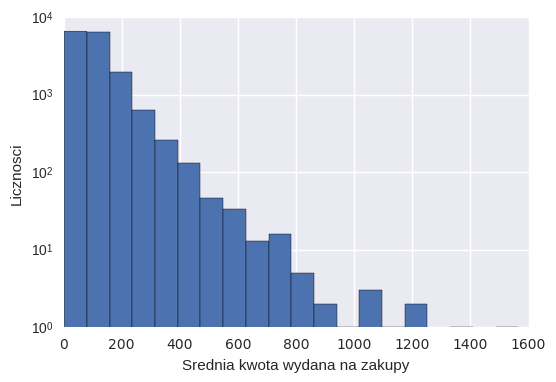

In [77]:
plt.hist(dt['AVRG'], bins=20)
plt.xlabel('Srednia kwota wydana na zakupy')
plt.ylabel('Licznosci')
ax = plt.subplot(1, 1, 1)
ax.set_yscale('log')
plt.show()

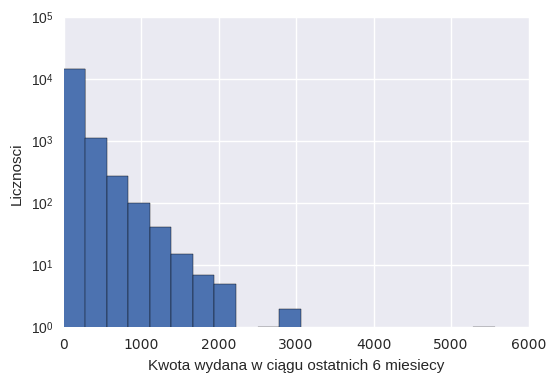

In [78]:
plt.hist(dt['TMONSPEND'], bins=20)
plt.xlabel('Kwota wydana w ciągu ostatnich 6 miesiecy')
plt.ylabel('Licznosci')
ax = plt.subplot(1, 1, 1)
ax.set_yscale('log')
plt.show()

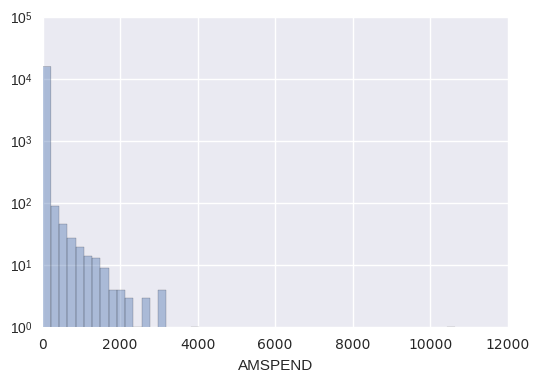

In [79]:
sns.distplot(dt['AMSPEND'], kde=False)
ax = plt.subplot(1, 1, 1)
ax.set_yscale('log')
plt.show()

Jak widać na powyższych wykresach rozkłady kwot są asymetryczne prawostronnie. Obserwacje odstające w przypadku każdej zmiennej bardzo różnią się od średniej (tym samym ich rozkład jest daleki od normalnego) i będą mocno zniekształcać wyniki modelowania. Tak więc dane należy poddać standaryzacji.